# Finding the Optimal Discrimination Threshold in Classification Problems

In [1]:
import pandas as pd
from pandas import CategoricalDtype
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.classifier.threshold import discrimination_threshold
import warnings

from interactive_discrimination_threshold import InteractiveDiscriminationThreshold

## Dataset and Model

Here we build a pipeline with a random forest classifier and train it on the "telco-customer-churn" dataset from [OpenML](https://www.openml.org/d/42178). Both static and dynamic versions of discrimination threshold below assume training the model multiple times on various subsets of the data, which implies that the model (actually, the pipeline) is error-prone, in particular, with respect to values of the dataset's categorical columns. In order make sure 

In [4]:
X, y = fetch_openml(name='telco-customer-churn', return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    "Transform string variables into categorical data variables and clean data."
    df = df.copy()
    df['gender'] = df['gender'].astype(CategoricalDtype(categories=['Male', 'Female']))
    for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
        df[col] = df[col].astype(CategoricalDtype(categories=['No', 'Yes']))
    for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']:
        df[col] = df[col].astype(CategoricalDtype(categories=['No', 'Yes', 'No internet service']))
    df['InternetService'] = (df['InternetService']
                             .astype(CategoricalDtype(categories=['Fiber optic', 'DSL', 'No'])))
    df['MultipleLines'] = (df['MultipleLines']
                           .astype(CategoricalDtype(categories=['No', 'Yes', 'No phone service'])))
    contract_categories = ['Month-to-month', 'Two year', 'One year']
    df['Contract'] = X['Contract'].astype(CategoricalDtype(categories=contract_categories))
    paymethod_categories = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
                            'Credit card (automatic)']
    df['PaymentMethod'] = (df['PaymentMethod']
                           .astype(CategoricalDtype(categories=paymethod_categories)))
    df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = '0'
    df['TotalCharges'] = df['TotalCharges'].astype(float)
    return df


X_train = transform_data(X_train)
X_test = transform_data(X_test)

encode_cat = ColumnTransformer([('cat', OrdinalEncoder(),
                                 make_column_selector(dtype_include='category'))],
                               remainder='passthrough')
model = Pipeline(steps=[
    ('encode_cat', encode_cat),
    ('rfc', RandomForestClassifier(n_estimators=50, oob_score=True))
])

## Existing Implementation

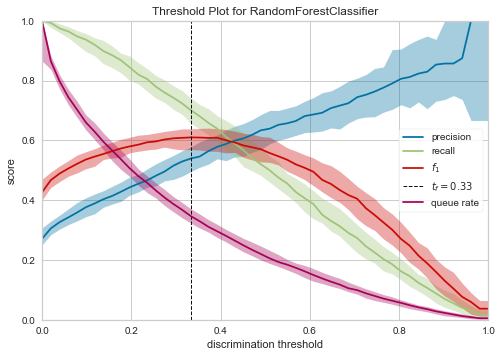

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X_train, (y_train == 'Yes').astype(int))

## Our Version

In [6]:
disc_threshold = InteractiveDiscriminationThreshold(model, X_train, y_train,
                                                    label_dict={0: 'No', 1: 'Yes'})
disc_threshold.prepare_data(store_data=True)

In [8]:
disc_threshold.plot(app_mode='external')

Dash app running on http://127.0.0.1:8050/
